# Code to compare train and test stage of DL model


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from lib.io_utils import *

In [2]:
project_dir = '../'
ml_dir = '{}ml/'.format(project_dir)
results_dir = '{}results/Exp_kaggle/'.format(project_dir)

In [3]:
# experiment_names = ['Exp_pytorch_cifar','Exp_kaggle_mateuszbuda','Exp_kaggle_mateuszbuda_pruned']
exp_idx = range(1,14)
experiment_names = ['Exp_kaggle_mateuszbuda_{}'.format(i) for i in exp_idx] #['Exp_kaggle_mateuszbuda','Exp_kaggle_mateuszbuda_pruned']

devices = ['cuda'] 

jcols = ['experiment_name','device','tag','duration','package_total','dram_total','nvidia_total','process_total']
exp_config_df_concat = pd.DataFrame()
epoch_df_concat = pd.DataFrame()
joules_df_concat = pd.DataFrame()
for exp_name in experiment_names:
    for device in devices:
        exp_config_csv = '{}{}/{}/experiment_config.csv'.format(results_dir,exp_name,device)
        epoch_csv = '{}{}/{}/epoch.csv'.format(results_dir,exp_name,device)
        joules_csv = '{}{}/{}/joules.csv'.format(results_dir,exp_name,device)

        exp_config_df = pd.read_csv(exp_config_csv)
        exp_config_df_concat = exp_config_df_concat.append(exp_config_df)

        epoch_df = pd.read_csv(epoch_csv)
        epoch_df['experiment_name'] = exp_name
        epoch_df['device'] = device
        epoch_df_concat = epoch_df_concat.append(epoch_df)
        
        
        joules_df = read_joules(joules_csv,device)
        joules_df['experiment_name'] = exp_name        
        joules_df_concat = joules_df_concat.append(joules_df[jcols])


exp_config_df_concat.head()

,MAC,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,arch,batch_size,count,device,experiment_compute_time,experiment_name,...,n_epochs,optimizer,params,proc,python_version,test_compute_time,test_perf,test_perf_selected,train_compute_time,valid_perf_selected
0,12.13 GMac,0,0,0.0,X86_64,4,32,cuda,160.268875,Exp_kaggle_mateuszbuda_1,...,20,adam,7.76 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.023897,60.458712,66.424563,72.467244,84.406171
0,12.13 GMac,0,0,NaN,X86_64,16,32,cuda,173.990355,Exp_kaggle_mateuszbuda_2,...,20,adam,7.76 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.021195,47.463502,59.672200,21.662458,68.495032
0,3.06 GMac,0,0,NaN,X86_64,4,32,cuda,191.985579,Exp_kaggle_mateuszbuda_3,...,20,adam,1.94 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.019465,50.567410,64.914389,61.571497,82.190923
0,3.06 GMac,0,0,NaN,X86_64,16,32,cuda,70.608759,Exp_kaggle_mateuszbuda_4,...,20,adam,1.94 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.017025,52.446383,54.826473,16.684447,57.916220
0,0.78 GMac,0,0,NaN,X86_64,4,32,cuda,110.922030,Exp_kaggle_mateuszbuda_5,...,20,adam,486.55 k,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.018801,31.060340,70.098792,58.338257,72.771825


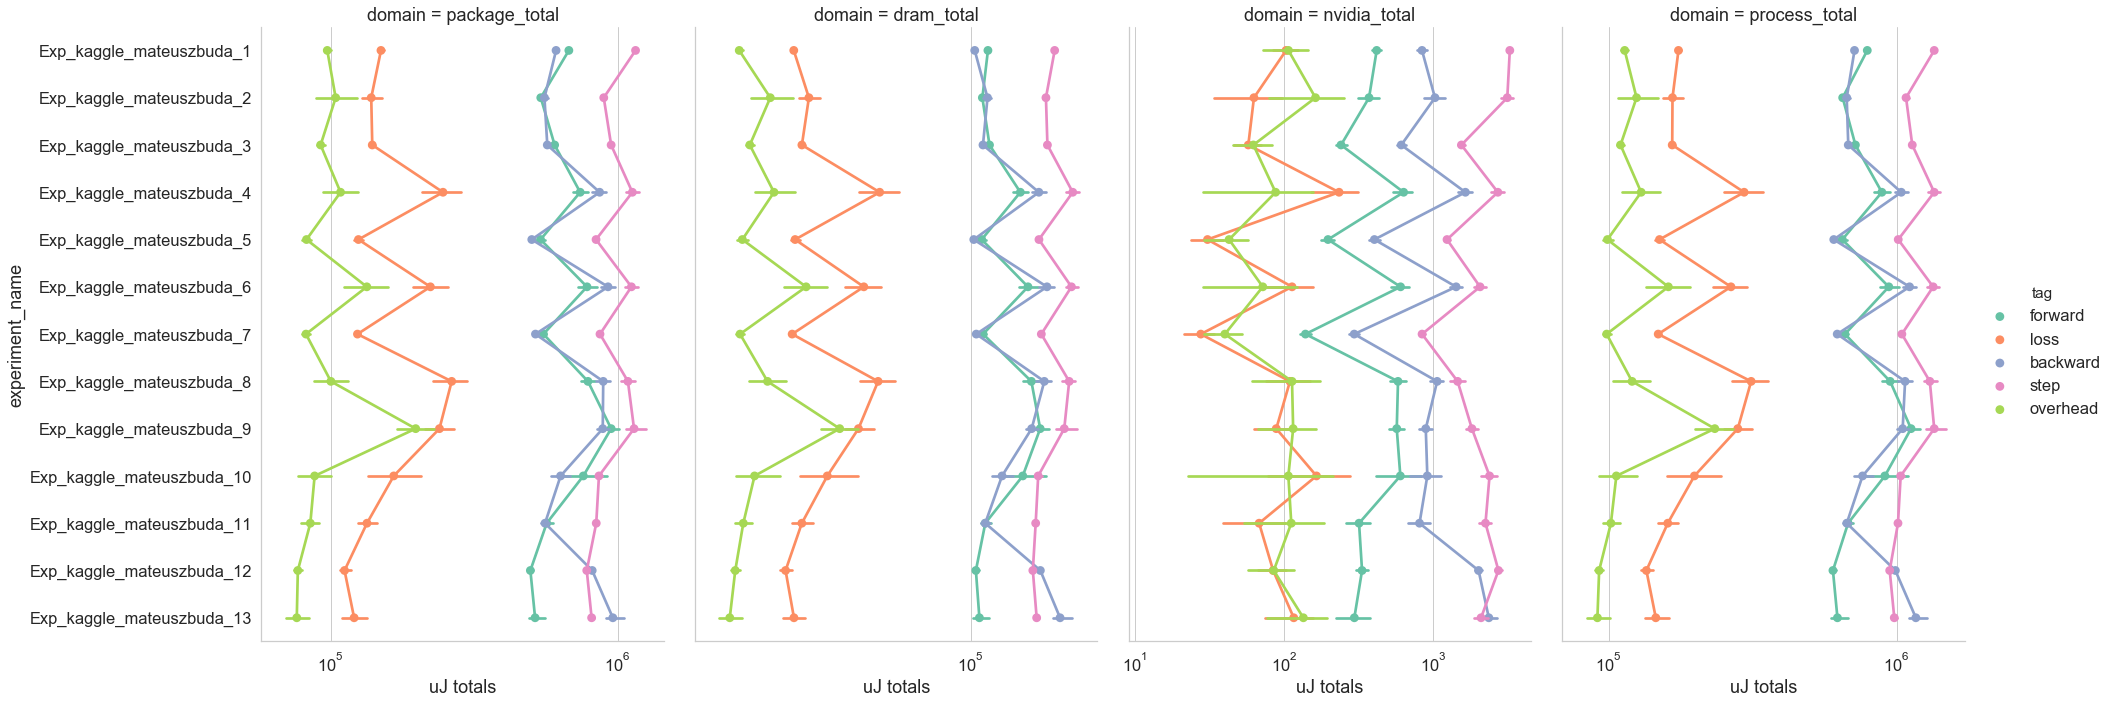

In [4]:
plot_df = joules_df_concat.copy()
plot_df = plot_df[plot_df['device']=='cuda']
plot_df = pd.melt(plot_df, id_vars=['experiment_name','device','tag','duration'], value_vars=['package_total','dram_total','nvidia_total','process_total'],
 var_name='domain', value_name='uJ totals')

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='experiment_name',x='uJ totals', hue='tag', col='domain', kind='point', data=plot_df, palette='Set2',height=10, aspect=0.7, sharex=False)
    g.set(xscale="log")

In [5]:
total_joules = plot_df[(plot_df['domain']=='process_total')&(plot_df['tag']!='overhead')]
total_joules = total_joules.groupby(['experiment_name','device','domain','tag']).mean().reset_index()
total_joules = total_joules.groupby(['experiment_name','device']).sum().reset_index()
total_joules = pd.merge(total_joules,exp_config_df_concat,on=['experiment_name','device'])
total_joules.head()

,experiment_name,device,duration,uJ totals,MAC,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,arch,batch_size,...,n_epochs,optimizer,params,proc,python_version,test_compute_time,test_perf,test_perf_selected,train_compute_time,valid_perf_selected
0,Exp_kaggle_mateuszbuda_1,cuda,0.026128,3.032663e+06,12.13 GMac,0,0,0.0,X86_64,4,...,20,adam,7.76 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.023897,60.458712,66.424563,72.467244,84.406171
1,Exp_kaggle_mateuszbuda_10,cuda,0.027879,2.905263e+06,12.13 GMac,0,0,0.0,X86_64,32,...,20,adam,7.76 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.030222,64.919252,62.418329,17.701124,66.067722
2,Exp_kaggle_mateuszbuda_11,cuda,0.024226,2.522757e+06,12.13 GMac,0,0,NaN,X86_64,16,...,20,adam,7.76 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.029825,46.933803,57.203430,27.869073,76.140483
3,Exp_kaggle_mateuszbuda_12,cuda,0.027341,2.674188e+06,48.28 GMac,0,0,NaN,X86_64,4,...,20,adam,31.04 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.054200,57.921152,73.867592,168.859461,86.068540
4,Exp_kaggle_mateuszbuda_13,cuda,0.029892,2.918274e+06,48.28 GMac,0,0,NaN,X86_64,16,...,20,adam,31.04 M,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,3.7.4.final.0 (64 bit),0.047592,51.945089,72.230790,49.340030,78.016863


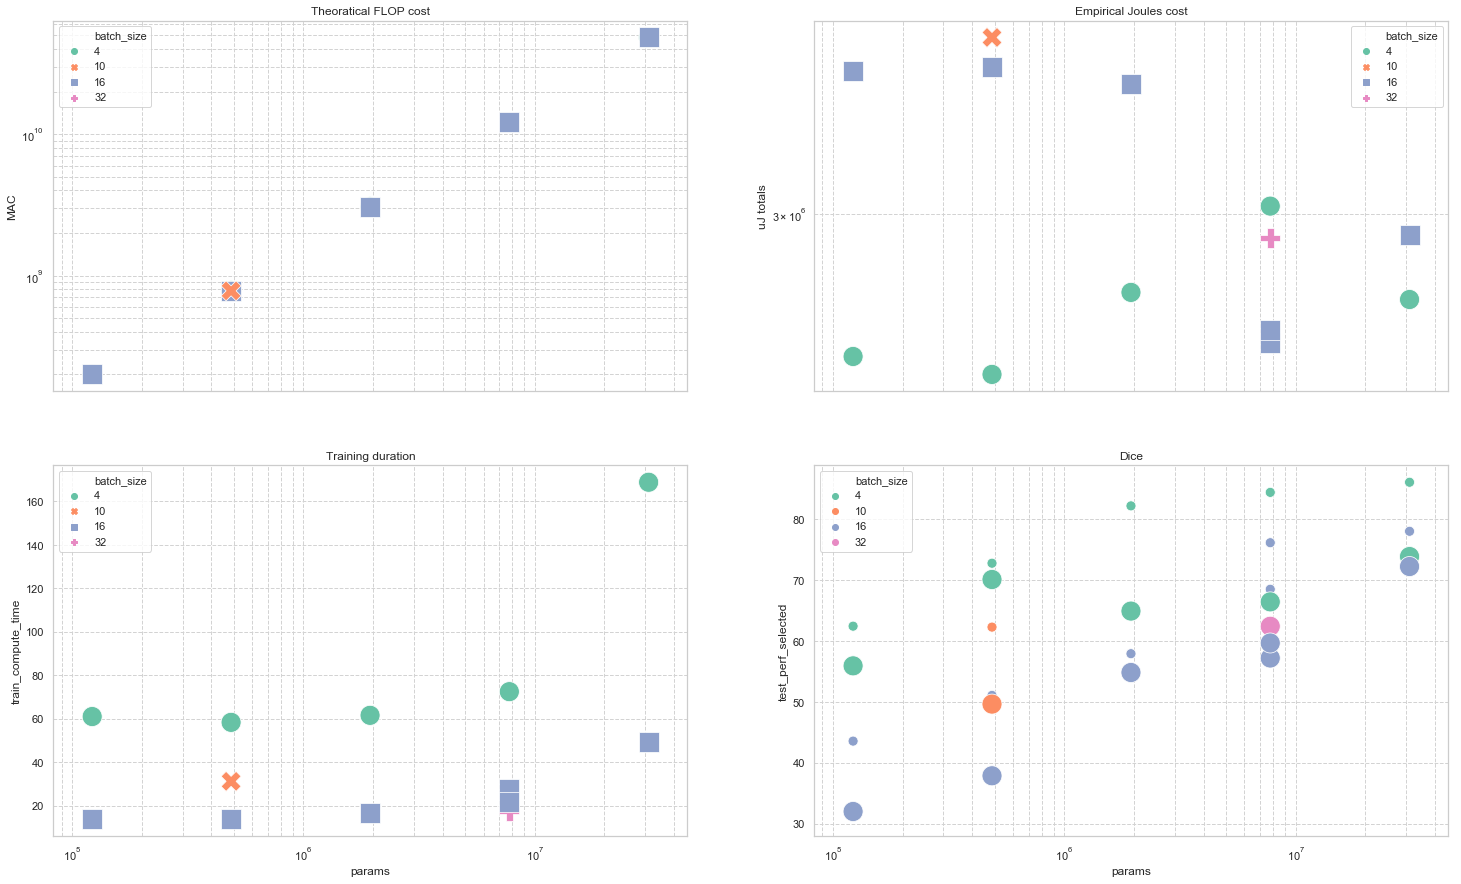

In [62]:
plot_df = total_joules.copy()
# plot_df['batch_size'] = plot_df['batch_size'].astype(str)
plot_df = convert_str_to_param_value(plot_df, 'params')
plot_df = convert_str_to_param_value(plot_df, 'MAC')
n_hues = len(plot_df['batch_size'].unique())
size_level_dict =  dict(zip(np.sort(plot_df['batch_size'].unique()), [100,200,300,400]))

sns.set(font_scale = 1)
palette = sns.color_palette("Set2", n_hues)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(2,2,figsize=(25,15),sharex=True,sharey=False)

    # FLOPs
    ax = axes.ravel()[0]
    g = sns.scatterplot(x='params',y='MAC', hue='batch_size', style='batch_size', s=400, data=plot_df, palette=palette,ax=ax) 
    g.set(xscale="log",yscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Theoratical FLOP cost')

    # Energy
    ax = axes.ravel()[1]
    g = sns.scatterplot(x='params',y='uJ totals', hue='batch_size', style='batch_size', s=400, data=plot_df, palette=palette,ax=ax)
    g.set(xscale="log",yscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Empirical Joules cost')

    # time
    ax = axes.ravel()[2]
    g = sns.scatterplot(x='params',y='train_compute_time', hue='batch_size', style='batch_size', s=400, data=plot_df, palette=palette,ax=ax)
    g.set(xscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Training duration')

    # Acc
    ax = axes.ravel()[3]
    g = sns.scatterplot(x='params',y='valid_perf_selected', hue='batch_size', s=100, legend=False, data=plot_df, palette=palette,ax=ax)
    g.set(xscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Dice')

    ax = axes.ravel()[3]
    g = sns.scatterplot(x='params',y='test_perf_selected', hue='batch_size', s=400, data=plot_df, palette=palette,ax=ax)
    g.set(xscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Dice')


In [44]:
size_level_dict

{4: 80, 32: 640, 16: 320, 10: 200}